In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import platform
from matplotlib import font_manager, rc

# '-' 기호 보이게 하기
matplotlib.rcParams['axes.unicode_minus'] = False

# 운영 체제마다 한글이 보이게 하는 설정
# 윈도우
if platform.system() == 'Windows':
    path = "c:\Windows\Fonts\malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
# 맥
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
# 리눅스
elif platform.system() == 'Linux':
    plt.rc('font', family='NanumBarunGothic')

# 데이터 불러오기

In [2]:
df_demo = pd.read_csv('data/LPOINT_BIG_COMP_01_DEMO.csv') # 고객정보
df_pdde = pd.read_csv('data/LPOINT_BIG_COMP_02_PDDE.csv', parse_dates = [6]) # 구매정보
df_copu = pd.read_csv('data/LPOINT_BIG_COMP_03_COP_U.csv', parse_dates = [5, 6]) # 유통사 이용 정보 (B01 ~ E00)
df_pd = pd.read_csv('data/LPOINT_BIG_COMP_04_PD_CLAC.csv') # 상품 정보

df_pdde['weekday'] = df_pdde['de_dt'].dt.weekday

C:\Users\Eugene\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### 식품/생활/여가별 변화 확인

In [3]:
# 상품분류
foods = ['건강식품', '건해산물', '과일', '과자', '냉동식품', '냉장식품', '대용식', '병통조림', '수산물', '주류', '채소'
         , '축산물', '커피/차', '양곡', '유제품', '음료', '조리식품', '조미료']

In [4]:
DF = pd.merge(df_pdde, df_demo, on = 'cust')
DF = pd.merge(DF, df_pd, on = 'pd_c')

In [5]:
DF_foods = DF.loc[(DF['ages'] == '20대')&(DF['clac_hlv_nm'].apply(lambda x: x in foods))]

In [6]:
food_dv = DF_foods.groupby(['cust', 'clac_hlv_nm'])['buy_ct'].sum().unstack()
food_dv = food_dv.fillna(0)

Text(0.5, 1.0, '식품 중분류 구매 횟수 상관관계')

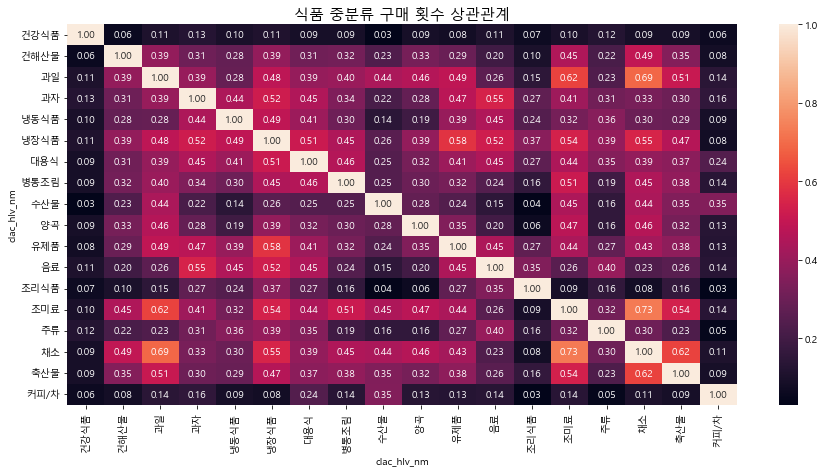

In [7]:
plt.figure(figsize=(15, 7))
sns.heatmap(food_dv.corr(), annot = True, fmt='.2f')
plt.title('식품 중분류 구매 횟수 상관관계', fontsize=15)

### 주성분 분석

- 식품 중분류를 카테고리별로 직접 나누지 않고 차원축소를 이용해 보았음.
- or 특정 선호가 있을법한 상품 생각해보기

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [9]:
X = food_dv.values
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=10)
pca_result = pca.fit_transform(X_scaled)
principalDF = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(10)])

In [10]:
result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(principalDF.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()
result

,설명가능한 분산 비율(고윳값),기여율,누적기여율
pca1,6.517088,0.361909,0.361909
pca2,1.765347,0.098034,0.459943
pca3,1.153674,0.064066,0.524009
pca4,0.985912,0.054750,0.578759
pca5,0.871609,0.048402,0.627162
pca6,0.785212,0.043605,0.670766
pca7,0.765834,0.042529,0.713295
pca8,0.694012,0.038540,0.751835
pca9,0.658154,0.036549,0.788384
pca10,0.561996,0.031209,0.819593


In [11]:
DFpca = pd.concat([food_dv.reset_index()[['cust']], principalDF.iloc[:, :9]], axis=1)
DFpca.head()

,cust,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,M000871427,-0.699358,-0.083995,0.066050,-0.052454,-0.680734,0.117279,0.070361,0.861331,0.304376
1,M001403108,-0.569406,-0.443695,1.254798,-0.288152,-0.126143,0.082854,0.193614,0.054687,0.058589
2,M002122238,-0.665293,0.871180,0.062160,-0.131108,-0.766844,-0.134640,-0.319346,-0.018427,-0.614469
3,M002188008,-1.206405,0.430146,0.096788,-0.162983,-0.403623,-0.003185,-0.204444,0.040032,-0.428402
4,M002238144,4.644177,3.024987,-0.328889,-1.039887,0.648555,1.450265,1.161106,-0.928704,0.264414


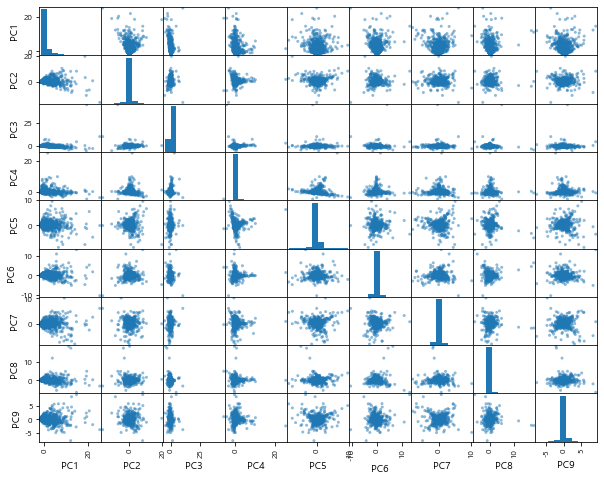

In [12]:
from pandas.plotting import scatter_matrix
scatter_matrix(DFpca.iloc[:, 1:], figsize = (10, 8))
plt.show()

## 주말 이용 비율

In [13]:
DF = DF.loc[(DF['ages'] == '20대')&(DF['cop_c'].apply(lambda x: x in ['A02', 'A03', 'A04']))]

In [14]:
# 주말 구분 컬럼 (금요일 6시부터 주말인 것으로 설정)
DF['weekend'] = 'weekday'
DF.loc[DF['de_hr'] > 17, 'weekend'] = 'weekend'
DF.loc[DF['weekday'] < 4, 'weekend'] = 'weekday'
DF.loc[DF['weekday'] > 4, 'weekend'] = 'weekday'

In [15]:
# 주말 마트 방문 비중 계산 
## 온라인을 포함하는게 맞나?
df_wk = DF.loc[DF['cop_c'] == 'A02'].groupby(['cust', 'weekend'])['rct_no'].unique().apply(lambda x: len(x)).unstack()
df_wk = df_wk.fillna(0)
df_wk['per_we'] = df_wk.weekend/(df_wk.weekday+df_wk.weekend)
df_wk

weekend,weekday,weekend,per_we
cust,,,
M000871427,9.0,2.0,0.181818
M001403108,21.0,3.0,0.125000
M002238144,58.0,6.0,0.093750
M003490042,3.0,0.0,0.000000
M004540352,1.0,0.0,0.000000
...,...,...,...
M997730983,20.0,1.0,0.047619
M998129365,1.0,0.0,0.000000
M998574012,24.0,2.0,0.076923


In [16]:
X_df = pd.merge(df_wk[['per_we']], DFpca[['cust', 'PC1']], left_index = True, right_on = 'cust')
print(X_df.shape)
X_df.head()

(1622, 3)


,per_we,cust,PC1
0,0.181818,M000871427,-0.699358
1,0.125000,M001403108,-0.569406
4,0.093750,M002238144,4.644177
7,0.000000,M003490042,-1.406086
9,0.000000,M004540352,-1.340188


## 카페 이용 빈도

In [17]:
dfD02 = df_copu[df_copu['cop_c'] == 'D02']
dfD02 = dfD02.groupby('cust')['rct_no'].unique().apply(lambda x: len(x)).to_frame('ang_count')
tenant = DF.loc[(DF['clac_hlv_nm'] == '테넌트/음식점')&(DF['pd_nm'] == '커피/음료')]
dftenent = tenant.groupby('cust')['rct_no'].unique().apply(lambda x: len(x)).to_frame('tenant_count')

dfcoffee = pd.merge(dfD02, dftenent, left_index = True, right_index = True)
n_coffee = (dfcoffee.ang_count + dfcoffee.tenant_count).to_frame('coffee')

X_df = pd.merge(X_df, n_coffee, left_on = 'cust', right_index = True, how = 'outer')
X_df = X_df.fillna(0)
print(X_df.shape)
X_df.head()

(1622, 4)


,per_we,cust,PC1,coffee
0,0.181818,M000871427,-0.699358,0.0
1,0.125000,M001403108,-0.569406,0.0
4,0.093750,M002238144,4.644177,0.0
7,0.000000,M003490042,-1.406086,0.0
9,0.000000,M004540352,-1.340188,0.0


## 소비 빈도/평균 소비 금액

RFM처럼 각 유통사별로 소비 빈도와 평균 소비 금액 특성 생성

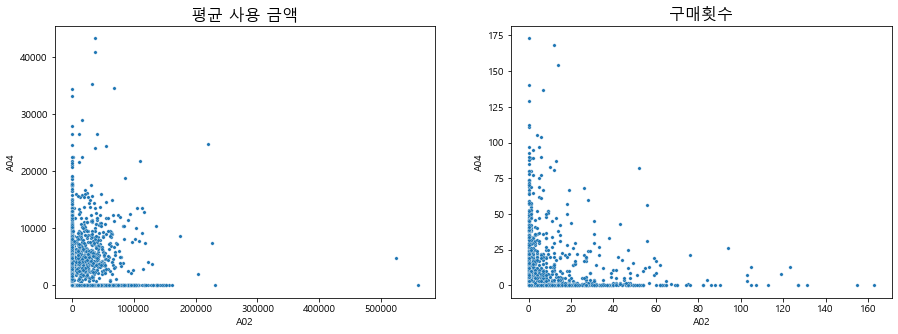

In [18]:
amount_food = (DF_foods.groupby(['cust', 'cop_c'])['buy_am'].sum()/DF_foods.groupby(['cust', 'cop_c'])['rct_no'].unique().apply(lambda x: len(x))).to_frame(name = 'amount_avg')
amount_food = amount_food.unstack()
amount_food.columns = [f'A0{i}' for i in range(1, 7)]
amount_food = amount_food.fillna(0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

sns.scatterplot(data = amount_food, x = 'A02', y = 'A04', s = 12, ax = ax1)

cnt_food = DF_foods.groupby(['cust', 'cop_c'])['rct_no'].unique().apply(lambda x: len(x)).unstack()
cnt_food = cnt_food.fillna(0)
cnt_food = cnt_food[cnt_food['A04'] < 300] # 구매횟수가 300회 이상인 데이터 제거
sns.scatterplot(data = cnt_food, x = 'A02', y = 'A04', s = 12, ax = ax2)

ax1.set_title('평균 사용 금액', fontsize = 16)
ax2.set_title('구매횟수', fontsize = 16)
plt.show()

In [19]:
amount_food = pd.merge(amount_food, df_demo[['cust', 'ages']], left_index=True, right_on='cust')

In [20]:
amount_food.columns = [f'M_A0{i}' for i in range(1, 7)]+['cust', 'ages']
cnt_food.columns = [f'F_A0{i}' for i in range(1, 7)]
FM_food = pd.merge(amount_food, cnt_food, left_on='cust', right_index = True)

Text(0.5, 1.0, 'F/M 상관관계')

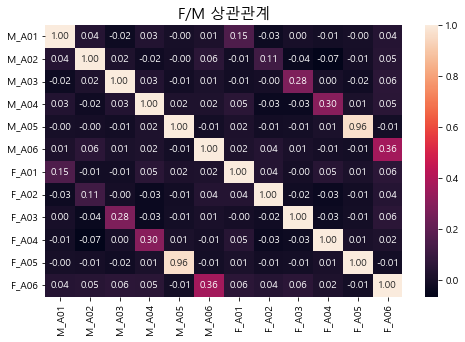

In [21]:
plt.figure(figsize=(8, 5))
sns.heatmap(FM_food.corr(), annot = True, fmt='.2f')
plt.title('F/M 상관관계', fontsize=15)

In [22]:
columns = ['cust']+[f'M_A0{i}' for i in range(2, 5)]+[f'F_A0{i}' for i in range(2, 5)]

X_df = pd.merge(X_df, FM_food[columns], on = 'cust')

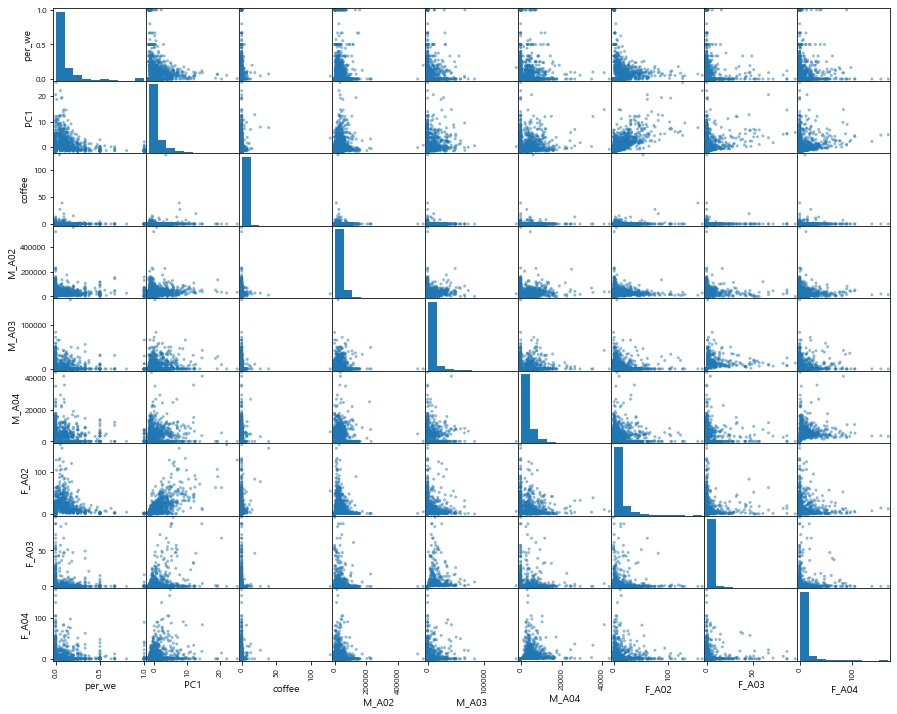

In [23]:
scatter_matrix(X_df, figsize = (15, 12))
plt.show()

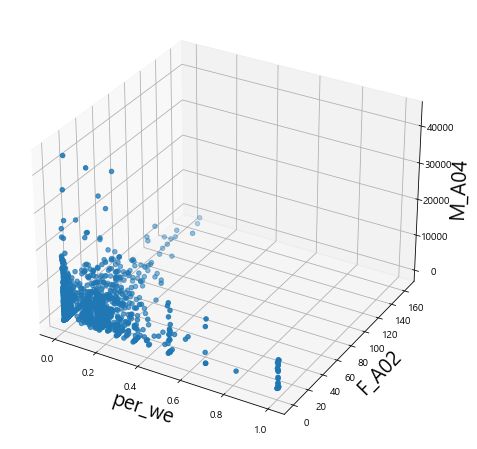

In [24]:
cols = ['per_we', 'F_A02', 'M_A04']

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d')
ax.scatter(X_df[cols[0]], X_df[cols[1]], X_df[cols[2]], s=20)
ax.set_xlabel(cols[0], fontsize=20)
ax.set_ylabel(cols[1], fontsize=20)
ax.set_zlabel(cols[2], fontsize=20)
plt.show()

# 이상치 제거

In [61]:
X_df

,per_we,cust,PC1,coffee,M_A02,M_A03,M_A04,F_A02,F_A03,F_A04
0,0.181818,M000871427,-0.699358,0.0,15679.000000,0.0,0.00000,10.0,0.0,0.0
1,0.125000,M001403108,-0.569406,0.0,15004.909091,4290.0,0.00000,22.0,1.0,0.0
2,0.093750,M002238144,4.644177,0.0,9277.785714,0.0,4293.75000,56.0,0.0,56.0
3,0.000000,M003490042,-1.406086,0.0,20095.000000,0.0,0.00000,2.0,0.0,0.0
4,0.000000,M004540352,-1.340188,0.0,62640.000000,0.0,0.00000,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1617,0.047619,M997730983,-0.060321,0.0,11680.000000,0.0,0.00000,19.0,0.0,0.0
1618,0.000000,M998129365,-1.428149,0.0,42460.000000,0.0,0.00000,1.0,0.0,0.0
1619,0.076923,M998574012,1.339555,0.0,10682.105263,6682.0,2583.58209,19.0,5.0,67.0
1620,0.000000,M998600186,-1.566599,0.0,18750.000000,0.0,0.00000,1.0,0.0,0.0


# 군집화

세 컬럼의 분포가 원형이 아니라서 밀도기반 군집화가 나을 것 같은데 k-means, DBSCAN 모두 사용해봄

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score

In [26]:
def RunKM(df, n_clusters, columns):
    km = KMeans(n_clusters=n_clusters, random_state=1)
    km.fit(df[columns].values)
    df['clus'] = km.labels_

    score_samples = silhouette_samples(df[columns], df['clus'])
    df['sil_coef'] = score_samples

    return df[['clus']]

In [36]:
def Optimize(df, n_clusters_list):
    fig = plt.figure(figsize=(6*len(n_clusters_list), 16))
    ax = []
    cols = ['per_we', 'F_A02', 'M_A04']

    columns = df.columns
    for i, n_clusters in enumerate(n_clusters_list):
        ax.extend([fig.add_subplot(2, len(n_clusters_list), i+1), fig.add_subplot(2, len(n_clusters_list), i+1+len(n_clusters_list), projection='3d')])
        RunKM(df_sc, n_clusters, columns)
        y_lower = 10

        for n in range(n_clusters):
            df_tmp = df[df['clus'] == n]
            sil_coef = df_tmp['sil_coef'].sort_values()
            clus_size = sil_coef.shape[0]
            y_upper = y_lower + clus_size

            ax[2*i].fill_betweenx(np.arange(y_lower, y_upper), 0, sil_coef)
            ax[2*i].text(-0.05, y_lower + 0.5 * clus_size, str(n))

            ax[2*i+1].scatter(df_tmp[cols[0]], df_tmp[cols[1]], df_tmp[cols[2]], label=n)

            y_lower = y_upper + 10
            del df_tmp

        avg_score = silhouette_score(df[columns], df['clus'])
        ax[2*i].axvline(x=avg_score, color="red", linestyle="--")
        ax[2*i].set_title('n_clusters : %d\nsilhouette score : %.3f' % (n_clusters, avg_score))
        
        ax[2*i+1].set_xlabel(cols[0], fontsize=20)
        ax[2*i+1].set_ylabel(cols[1], fontsize=20)
        ax[2*i+1].set_zlabel(cols[2], fontsize=20)
        ax[2*i+1].legend()

    plt.show()

In [43]:
X_sc = StandardScaler().fit_transform(X_df[['per_we', 'PC1', 'coffee', 'M_A02', 'M_A03', 'M_A04', 'F_A02', 'F_A03', 'F_A04']].values)
df_sc = pd.DataFrame(X_sc, columns = ['per_we', 'PC1', 'coffee', 'M_A02', 'M_A03', 'M_A04', 'F_A02', 'F_A03', 'F_A04'])

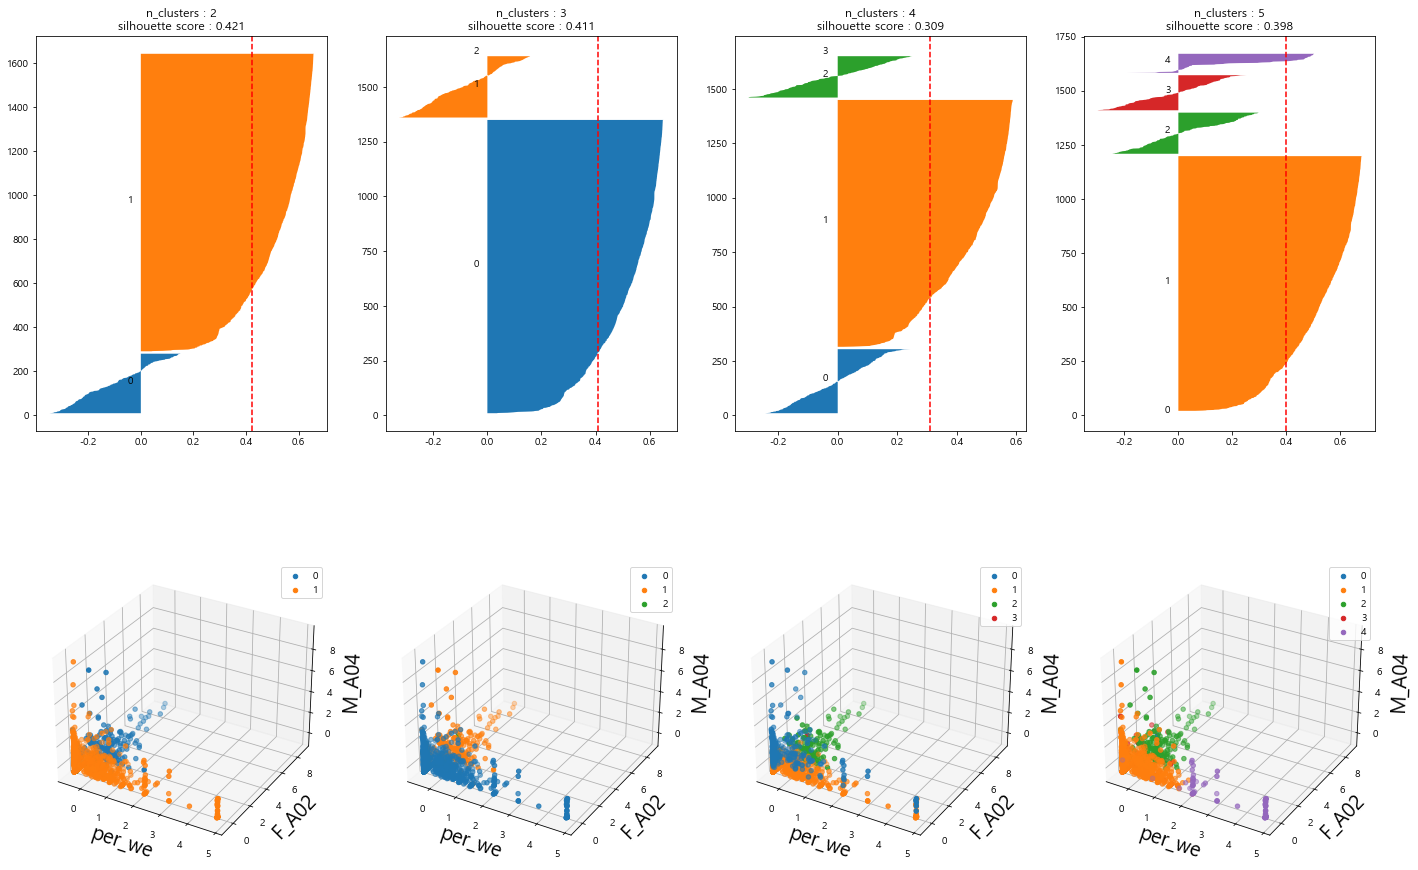

In [38]:
Optimize(df_sc, [i for i in range(2, 6)])

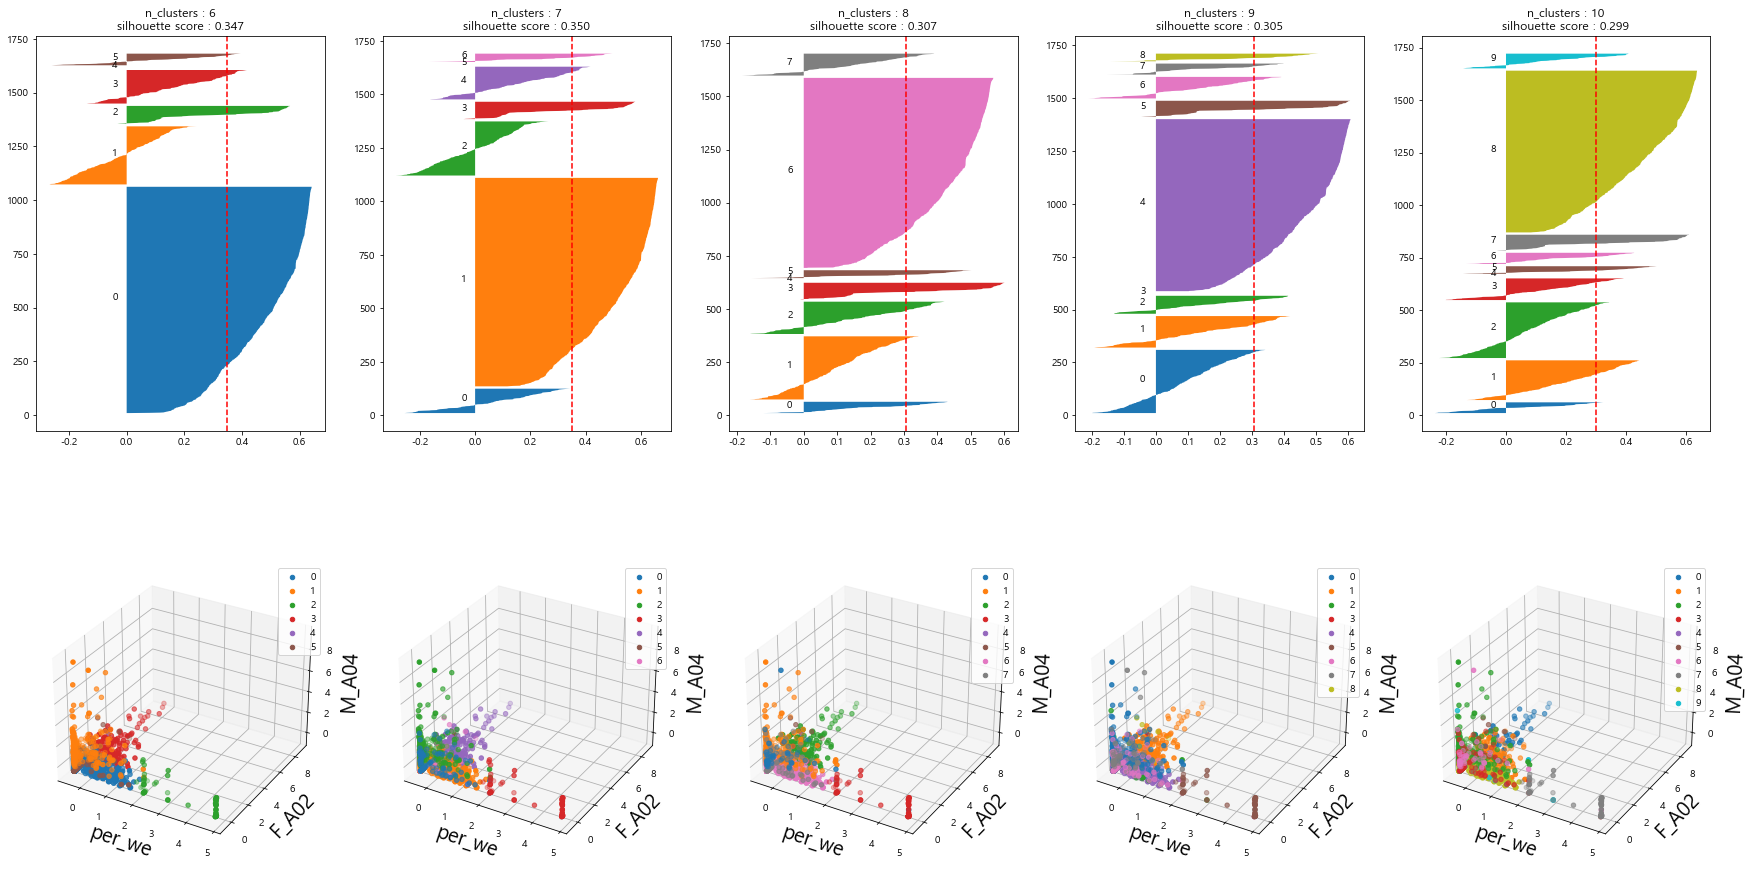

In [45]:
Optimize(df_sc, [i for i in range(6, 11)])

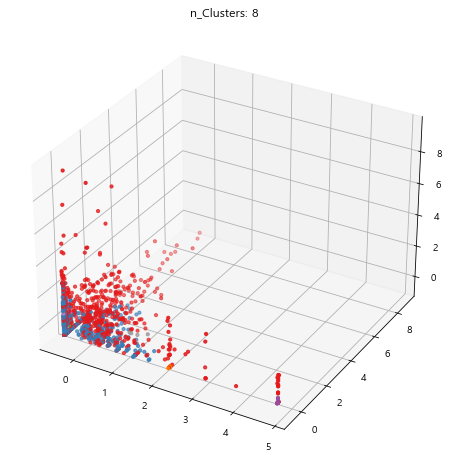

In [59]:
from sklearn.cluster import DBSCAN

X = df_sc.iloc[:, :-2].copy()
db = DBSCAN(eps = 0.5)
db.fit(X.values)
X['clus'] = db.labels_
n_clusters = len(X['clus'].unique())

cols = ['per_we', 'F_A02', 'M_A04']

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d')
ax.scatter(X[cols[0]], X[cols[1]], X[cols[2]], s=10, c=X["clus"], marker='o', cmap = 'Set1')
ax.set_title(f'n_Clusters: {n_clusters -1}')
plt.show()

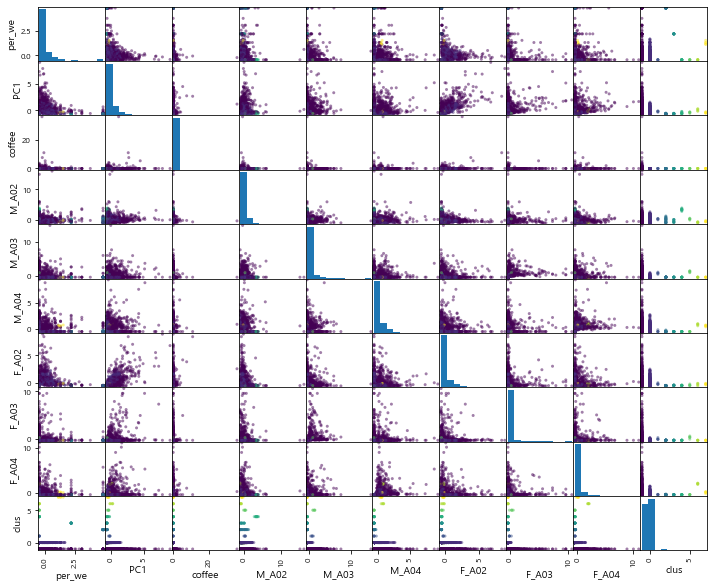

In [60]:
# DBSCAN 결과 분포 시각화
scatter_matrix(X, figsize=(12,10), c = X['clus'])
plt.show()